In [200]:
from collections import defaultdict
import numpy as np 
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

In [201]:
data_df = pd.read_json('json_data/All_Beauty.json', lines=True)

In [202]:
data_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [203]:
data_df.shape

(5269, 12)

In [204]:
data_df.dtypes

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
image             object
dtype: object

In [205]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         5269 non-null   int64 
 1   verified        5269 non-null   bool  
 2   reviewTime      5269 non-null   object
 3   reviewerID      5269 non-null   object
 4   asin            5269 non-null   object
 5   style           4624 non-null   object
 6   reviewerName    5269 non-null   object
 7   reviewText      5264 non-null   object
 8   summary         5264 non-null   object
 9   unixReviewTime  5269 non-null   int64 
 10  vote            552 non-null    object
 11  image           98 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 458.1+ KB


In [206]:
print('Number of missing values across columns: \n',data_df.isnull().sum())

Number of missing values across columns: 
 overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style              645
reviewerName         0
reviewText           5
summary              5
unixReviewTime       0
vote              4717
image             5171
dtype: int64


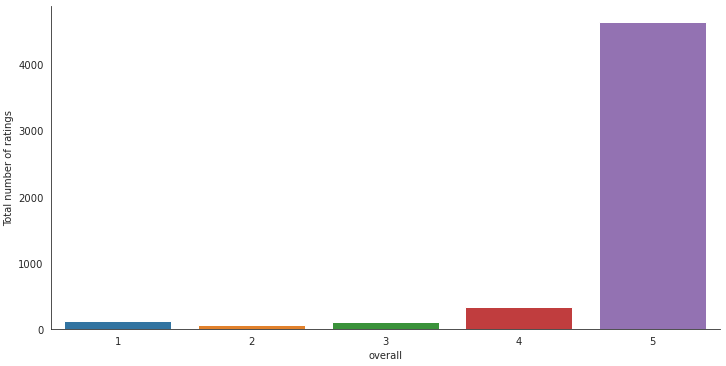

In [207]:
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=data_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [208]:
no_of_rated_products_per_user = data_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

asin
B0012Y0ZG2    1794
B000URXP6E     858
B001OHV1H4     489
B00006L9LC     489
B0009RF9DW     392
Name: overall, dtype: int64

In [209]:
no_of_rated_products_per_user.describe()

count      85.000000
mean       61.988235
std       230.395390
min         1.000000
25%         2.000000
50%         6.000000
75%        13.000000
max      1794.000000
Name: overall, dtype: float64

In [210]:
##Collaborative Filtering
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold
import os
from surprise.model_selection import train_test_split

In [211]:
reader = Reader(rating_scale=(1, 5))
new_df = data_df[['reviewerID','asin','overall']]
data = Dataset.load_from_df(new_df,reader)

In [212]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [213]:
# algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
# algo.fit(trainset)

In [214]:
algo = SVD()
algo.fit(trainset)

In [215]:
test_pred = algo.test(testset)

## Calculating RMSE AND MAE VALUES

In [216]:
accuracy.rmse(test_pred, verbose=True)


RMSE: 0.5007


0.5006772466954722

In [217]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.2334


0.2333882938553552

In [218]:
def get_top_n(predictions, n=10):

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [219]:
bigTestSet = trainset.build_anti_testset()
allPredictions = algo.test(bigTestSet)
top_n = get_top_n(allPredictions, n=10)

## Calculating Convertion Rate

In [220]:

def ConverationRate(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0

    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutID = leftOut[1]
        hit = False
        for itemID, predictedRating in topNPredicted[userID]:
            if (leftOutID == itemID):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    return hits/total
print("\nConveration Rate: ", ConverationRate(top_n, test_pred))

def CumulativeConverationRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
    hits = 0
    total = 0
    for userID, leftOutItemID, actualRating, estimatedRating, _ in leftOutPredictions:
        if (actualRating >= ratingCutoff):
            hit = False
            for itemID, predictedRating in topNPredicted[userID]:
                if (leftOutItemID == itemID):
                    hit = True
                    break
            if (hit) :
                hits += 1
            total += 1

    return hits/total
print("Cumulative Converation Rate (rating >= 4): ", CumulativeConverationRate(top_n, test_pred, 4.0))


Converation Rate:  0.25869702719797594
Cumulative Converation Rate (rating >= 4):  0.2730950775455158


## Calculating Precision , Recall and F-measure

In [221]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

kf = KFold(n_splits=5)
algo = SVD()
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
    
    cumulative_precision = sum(prec for prec in precisions.values()) / len(precisions)
    cumulative_recall = sum(rec for rec in recalls.values()) / len(recalls)
    print("Precision:" ,cumulative_precision)
    print("Recall:" , cumulative_recall)
    print("F-Measure",2*((cumulative_precision*cumulative_recall)/(cumulative_precision+cumulative_recall)) )


Precision: 0.9420104314841156
Recall: 0.9457088667614983
F-Measure 0.9438560261202997


Precision: 0.9331366764995085
Recall: 0.9353490658800393
F-Measure 0.9342415613947189


Precision: 0.9421844181459568
Recall: 0.9423076923076923
F-Measure 0.9422460511948312


Precision: 0.937530149541727
Recall: 0.9406657018813314
F-Measure 0.9390953083890421


Precision: 0.9541666666666666
Recall: 0.954656862745098
F-Measure 0.9544117017633966
